# Question 4: Multiclass Classification
"Consider a three classes problem with three out of the five ethnicities in the dataset.
 Implement an SVM strategy for multiclass classification (either one against one or one
 against all). For this task, it is not mandatory to use k-fold cross validation to tune SVMs
 hyperparameters."

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import sys 

current_notebook_dir = os.getcwd()
base_dir_q2 = os.path.abspath(os.path.join(current_notebook_dir, "..", "Question 2"))
sys.path.append(base_dir_q2)
from Functions_22_Avino_Lombardi import gaussian_kernel, polynomial_kernel, compute_accuracy

base_dir_q3 = os.path.abspath(os.path.join(current_notebook_dir, "..", "Question 3"))
sys.path.append(base_dir_q3)

base_dir_q4 = os.path.abspath(os.path.join(current_notebook_dir))
sys.path.append(base_dir_q4)

from Functions_24_Avino_Lombardi import MulticlassSVM, _get_mvp_decision_function_scores

## Inspecting the new dataset

In [2]:
data = pd.read_csv("../dataset/ETHNICITY_CLASSIFICATION.csv")
data.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,gt
0,0.502792,-0.349373,-0.068018,-0.627533,0.130331,0.373488,-0.491088,0.416753,-0.046255,0.325566,...,0.374539,-0.605601,0.579226,-0.119241,0.185425,-0.255194,0.705415,-0.027761,0.581276,0
1,0.741646,-0.240194,-0.006548,-0.639129,-0.059524,0.457087,-0.500733,0.345128,-0.040395,0.334946,...,0.353851,-0.651629,0.129014,-0.034723,0.392575,-0.289928,0.380891,-0.157109,0.742231,0
2,2.836617,1.256781,2.227900,-0.603728,0.200403,1.366685,-0.666864,1.156750,-0.004516,0.767839,...,0.265453,-0.762246,-0.331476,0.051758,1.255034,-0.529064,1.412283,1.182029,3.046791,0
3,2.576996,1.784919,3.166102,-0.539903,0.108954,1.773622,-0.708488,2.679638,-0.313469,1.817676,...,0.295006,-0.866968,2.203584,-0.428082,-0.368396,-0.398743,4.043780,2.281445,5.065996,0
4,1.614504,1.103544,0.755605,-0.561434,-0.551708,0.936586,-0.575693,0.533321,0.033991,0.980126,...,0.155448,-0.825574,-0.627675,0.060466,0.815617,-0.434781,0.040881,-0.152861,2.191638,0


In [3]:
# Check basic information and class balance
print("Shape:", data.shape)
print("\nColumns:", data.columns.tolist())
print("\nClass distribution:\n", data["gt"].value_counts())

Shape: (2500, 33)

Columns: ['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6', 'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12', 'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18', 'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23', 'feat_24', 'feat_25', 'feat_26', 'feat_27', 'feat_28', 'feat_29', 'feat_30', 'feat_31', 'feat_32', 'gt']

Class distribution:
 gt
0    500
1    500
2    500
3    500
4    500
Name: count, dtype: int64


Given the balanced rapresentation of all five classes, we can choose three among them uniformly at random, or simply keep the first three classes

In [4]:
selected_classes = [0, 1, 2]

subset = data[data['gt'].isin(selected_classes)].copy()
# separate features from ground thruth
X = subset.drop('gt', axis=1).values
y = subset['gt'].values

## Data splitting

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 1234, stratify=y) # stratify to keep class proportions balanced

# check
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

from collections import Counter
print(f"Train label distribution: {Counter(y_train)}")
print(f"Test label distribution: {Counter(y_test)}")

Shape of X_train: (1200, 32)
Shape of y_train: (1200,)
Shape of X_test: (300, 32)
Shape of y_test: (300,)
Train label distribution: Counter({np.int64(2): 400, np.int64(1): 400, np.int64(0): 400})
Test label distribution: Counter({np.int64(0): 100, np.int64(1): 100, np.int64(2): 100})


## Standardizing and Scaling

In [6]:
scaler = StandardScaler()
# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Implementation

The `MulticlassSVM` class implements a multiclass Support Vector Machine (SVM) classifier using either **One-vs-Rest** (OvR) **or One-vs-One** (OvO) strategies. It relies on the custom binary SVM solver implemented in Question 3, the Most Violating Pair (`MVP`) algorithm, as its base estimator.

This class:

- Trains one or more binary MVP classifiers depending on the chosen strategy.

- Aggregates binary predictions to make multiclass decisions.

- Supports flexible kernel functions via user-defined kernel callable and parameters.

## Hyperparameters Tuning and Final Model
Due to the distinct characteristics of the `ETHNICITY_CLASSIFICATION` dataset, the optimal hyperparameters identified through cross-validation for the binary classification task (Question 2), are no longer suitable for the current research objective.

Therefore, we perform a new **5-fold cross-validation** procedure to tune the hyperparameters — including kernel type, kernel parameters, and classification strategy (one-vs-rest or one-vs-one) — aiming to maximize validation accuracy. The final model is then trained using the **best-performing configuration**.


In [7]:
print("\n--- Starting Hyperparameter Tuning with Cross-Validation ---")

# Define hyperparameter grids
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'kernel_type': ['gaussian', 'polynomial'],
    'gamma': [0.001, 0.01, 0.1, 1, 10], # For Gaussian kernel
    'p': [2, 3, 4], # For Polynomial kernel
    'strategy': ['ovr', 'ovo'] # Multiclass strategy
}

best_score = -np.inf
best_hyperparams = {}
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5-fold CV

# Store results for analysis
results = []

# Iterate over all combinations of hyperparameters
for C_val in param_grid['C']:
    for strategy_val in param_grid['strategy']:
        for kernel_type_val in param_grid['kernel_type']:
            kernel_params_to_use = {}
            kernel_func_to_use = None
            kernel_param_name = None # To store 'gamma' or 'p'

            if kernel_type_val == 'gaussian':
                kernel_func_to_use = gaussian_kernel
                kernel_param_name = 'gamma'
                param_vals = param_grid['gamma']
            elif kernel_type_val == 'polynomial':
                kernel_func_to_use = polynomial_kernel
                kernel_param_name = 'p'
                param_vals = param_grid['p']
            else:
                continue 

            for param_val in param_vals:
                kernel_params_to_use = {kernel_param_name: param_val}
                
                fold_accuracies = []
                fold_total_cpu_times = []
                fold_total_iterations = []
                fold_avg_final_M_minus_m = []
                fold_avg_final_dual_obj = []

                print(f"\nEvaluating: C={C_val}, Strategy={strategy_val}, Kernel={kernel_type_val}, {kernel_param_name}={param_val}")

                for fold, (train_index, val_index) in enumerate(kf.split(X_train_scaled, y_train)):
                    X_fold_train, X_fold_val = X_train_scaled[train_index], X_train_scaled[val_index]
                    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]

                    #  MulticlassSVM with current hyperparameters
                    model = MulticlassSVM(
                        C=C_val,
                        kernel_func=kernel_func_to_use,
                        kernel_params=kernel_params_to_use,
                        strategy=strategy_val,
                        tol=1e-3,
                        max_iter=1000 # Max iterations for each binary MVP model
                    )
                    
                    # Fit the model
                    model.fit(X_fold_train, y_fold_train)
                    
                    # Make predictions on the validation set
                    y_fold_val_pred = model.predict(X_fold_val)
                    
                    # Calculate accuracy
                    accuracy = compute_accuracy(y_fold_val, y_fold_val_pred)
                    fold_accuracies.append(accuracy)

                    # Collect metrics from the trained model
                    fold_total_cpu_times.append(model.total_cpu_time)
                    fold_total_iterations.append(model.total_iterations)
                    fold_avg_final_M_minus_m.append(model.avg_final_M_minus_m)
                    fold_avg_final_dual_obj.append(model.avg_final_dual_obj)

                    print(f"  Fold {fold+1} Validation Accuracy: {accuracy:.4f}")

                avg_accuracy = np.mean(fold_accuracies)
                avg_total_cpu_time = np.mean(fold_total_cpu_times)
                avg_total_iterations = np.mean(fold_total_iterations)
                avg_m_minus_m = np.mean(fold_avg_final_M_minus_m)
                avg_dual_obj = np.mean(fold_avg_final_dual_obj)

                print(f"  Average Validation Accuracy for this config: {avg_accuracy:.4f}")

                current_config_results = {
                    'C': C_val,
                    'strategy': strategy_val,
                    'kernel_type': kernel_type_val,
                    kernel_param_name: param_val,
                    'avg_val_accuracy': avg_accuracy,
                    'avg_total_cpu_time': avg_total_cpu_time,
                    'avg_total_iterations': avg_total_iterations,
                    'avg_m_minus_m': avg_m_minus_m,
                    'avg_dual_obj': avg_dual_obj
                }
                results.append(current_config_results)

                if avg_accuracy > best_score:
                    best_score = avg_accuracy
                    best_hyperparams = {
                        'C': C_val,
                        'strategy': strategy_val,
                        'kernel_type': kernel_type_val,
                        kernel_param_name: param_val
                    }

print("\n Hyperparameter Tuning Complete ---")
print(f"Best Validation Accuracy: {best_score:.4f}")
print(f"Best Hyperparameters: {best_hyperparams}")

results_df = pd.DataFrame(results)
print("\nAll Hyperparameter Tuning Results:")
display(results_df.sort_values(by='avg_val_accuracy', ascending=False))


--- Starting Hyperparameter Tuning with Cross-Validation ---

Evaluating: C=0.01, Strategy=ovr, Kernel=gaussian, gamma=0.001
Starting Multiclass SVM training with OVR strategy...
Training 3 One-vs-Rest (OvR) binary SVMs.
  Training OvR classifier for class '0' (1/3)...
[Converged via KKT gap] Iteration 323, m-M = 0.000582 < tol = 0.001
  Training OvR classifier for class '1' (2/3)...
[Converged via KKT gap] Iteration 324, m-M = 0.000502 < tol = 0.001
  Training OvR classifier for class '2' (3/3)...
[Converged via KKT gap] Iteration 326, m-M = 0.000553 < tol = 0.001
OvR training complete.
  Fold 1 Validation Accuracy: 0.6125
Starting Multiclass SVM training with OVR strategy...
Training 3 One-vs-Rest (OvR) binary SVMs.
  Training OvR classifier for class '0' (1/3)...
[Converged via KKT gap] Iteration 324, m-M = 0.000192 < tol = 0.001
  Training OvR classifier for class '1' (2/3)...
[Converged via KKT gap] Iteration 324, m-M = 0.000201 < tol = 0.001
  Training OvR classifier for class '

,C,strategy,kernel_type,gamma,avg_val_accuracy,avg_total_cpu_time,avg_total_iterations,avg_m_minus_m,avg_dual_obj,p
34,1.00,ovr,gaussian,0.10,0.905833,0.413554,643.0,0.329359,-133.289900,NaN
42,1.00,ovo,gaussian,0.10,0.904167,0.226870,509.6,0.224142,-91.065468,NaN
33,1.00,ovr,gaussian,0.01,0.902500,0.339350,508.2,0.210678,-156.587206,NaN
18,0.10,ovr,gaussian,0.10,0.899167,2.289774,985.0,0.009513,-24.897071,NaN
41,1.00,ovo,gaussian,0.01,0.898333,0.153557,338.2,0.266984,-107.346016,NaN
...,...,...,...,...,...,...,...,...,...,...
13,0.01,ovo,polynomial,NaN,0.228333,0.300930,233.0,4.021051,-0.129231,2.0
5,0.01,ovr,polynomial,NaN,0.130000,0.574800,308.8,4.139107,-0.136275,2.0
21,0.10,ovr,polynomial,NaN,0.124167,0.299767,427.6,4.335926,-0.196446,2.0
37,1.00,ovr,polynomial,NaN,0.124167,0.288370,427.6,4.335926,-0.196446,2.0


## Final Training


 --- Training Final Model with Best Hyperparameters ---

Setting values of the hyperparameters:
  C: 1
  Kernel: Gaussian ({'gamma': 0.1})
  Strategy: OVR
  Tolerance (tol): 0.001
  Max Iterations per binary SVM: 1000
Starting Multiclass SVM training with OVR strategy...
Training 3 One-vs-Rest (OvR) binary SVMs.
  Training OvR classifier for class '0' (1/3)...
[Early Stopping] Iteration 118, no violating pair found that allows progress.
  Training OvR classifier for class '1' (2/3)...
[Early Stopping] Iteration 333, no violating pair found that allows progress.
  Training OvR classifier for class '2' (3/3)...
[Early Stopping] Iteration 481, no violating pair found that allows progress.
OvR training complete.

 --- Evaluating Final Model ---

Classification rate on training and test sets:
  Train Accuracy: 0.9167
  Test Accuracy: 0.9067

Optimization time (sum of CPU times for all binary models): 1.3609 seconds
Number of optimization iterations (sum of iterations for all binary models)

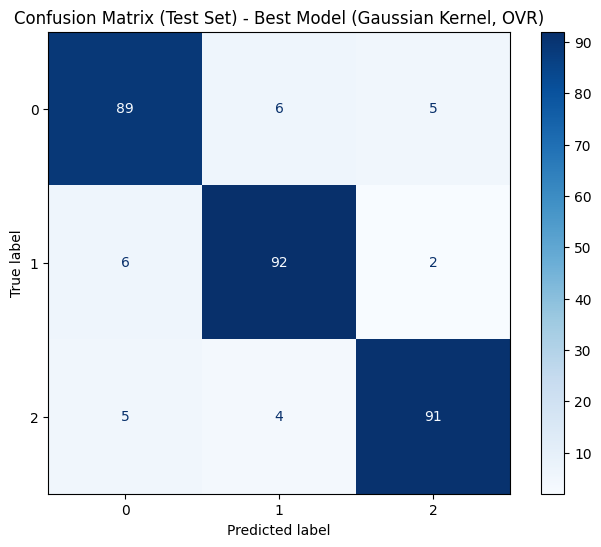

Raw Confusion Matrix:
[[89  6  5]
 [ 6 92  2]
 [ 5  4 91]]


In [8]:
print("\n --- Training Final Model with Best Hyperparameters ---")

final_kernel_func = None
final_kernel_params = {}
if best_hyperparams['kernel_type'] == 'gaussian':
    final_kernel_func = gaussian_kernel
    final_kernel_params = {'gamma': best_hyperparams['gamma']}
elif best_hyperparams['kernel_type'] == 'polynomial':
    final_kernel_func = polynomial_kernel
    final_kernel_params = {'p': best_hyperparams['p']}

final_model = MulticlassSVM(
    C=best_hyperparams['C'],
    kernel_func=final_kernel_func,
    kernel_params=final_kernel_params,
    strategy=best_hyperparams['strategy'],
    tol=1e-3,
    max_iter=1000
)

print(f"\nSetting values of the hyperparameters:")
print(f"  C: {final_model.C}")
print(f"  Kernel: {best_hyperparams['kernel_type'].capitalize()} ({final_kernel_params})")
print(f"  Strategy: {final_model.strategy.upper()}")
print(f"  Tolerance (tol): {final_model.tol}")
print(f"  Max Iterations per binary SVM: {final_model.max_iter}")

final_model.fit(X_train_scaled, y_train)


# --- Evaluate Final Model ---
print("\n --- Evaluating Final Model ---")

# Predictions on training set
final_train_predictions = final_model.predict(X_train_scaled)
train_accuracy = compute_accuracy(y_train, final_train_predictions)

# Predictions on test set
final_test_predictions = final_model.predict(X_test_scaled)
test_accuracy = compute_accuracy(y_test, final_test_predictions)

print(f"\nClassification rate on training and test sets:")
print(f"  Train Accuracy: {train_accuracy:.4f}")
print(f"  Test Accuracy: {test_accuracy:.4f}")

print(f"\nOptimization time (sum of CPU times for all binary models): {final_model.total_cpu_time:.4f} seconds")
print(f"Number of optimization iterations (sum of iterations for all binary models): {final_model.total_iterations}")
print(f"Final difference m(λ) - M(λ) (average across binary models): {final_model.avg_final_M_minus_m:.6f}")
print(f"Final value of the dual SVM objective (average across binary models): {final_model.avg_final_dual_obj:.6f}")


# --- Generate Confusion Matrix for the best model ---
y_test_flat = y_test.ravel() if y_test.ndim > 1 else y_test
final_test_predictions_flat = final_test_predictions.ravel() if final_test_predictions.ndim > 1 else final_test_predictions

# Get class labels from the final model
class_labels = final_model.classes_

cm = confusion_matrix(y_test_flat, final_test_predictions_flat, labels=class_labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title(f'Confusion Matrix (Test Set) - Best Model ({best_hyperparams["kernel_type"].capitalize()} Kernel, {best_hyperparams["strategy"].upper()})')
plt.show()

print("Raw Confusion Matrix:")
print(cm)
